Поиск цен на момент покупки...

Учтено покупок после поиска цен: 4
Расчет относительной стоимости портфеля...
Расчет завершен.


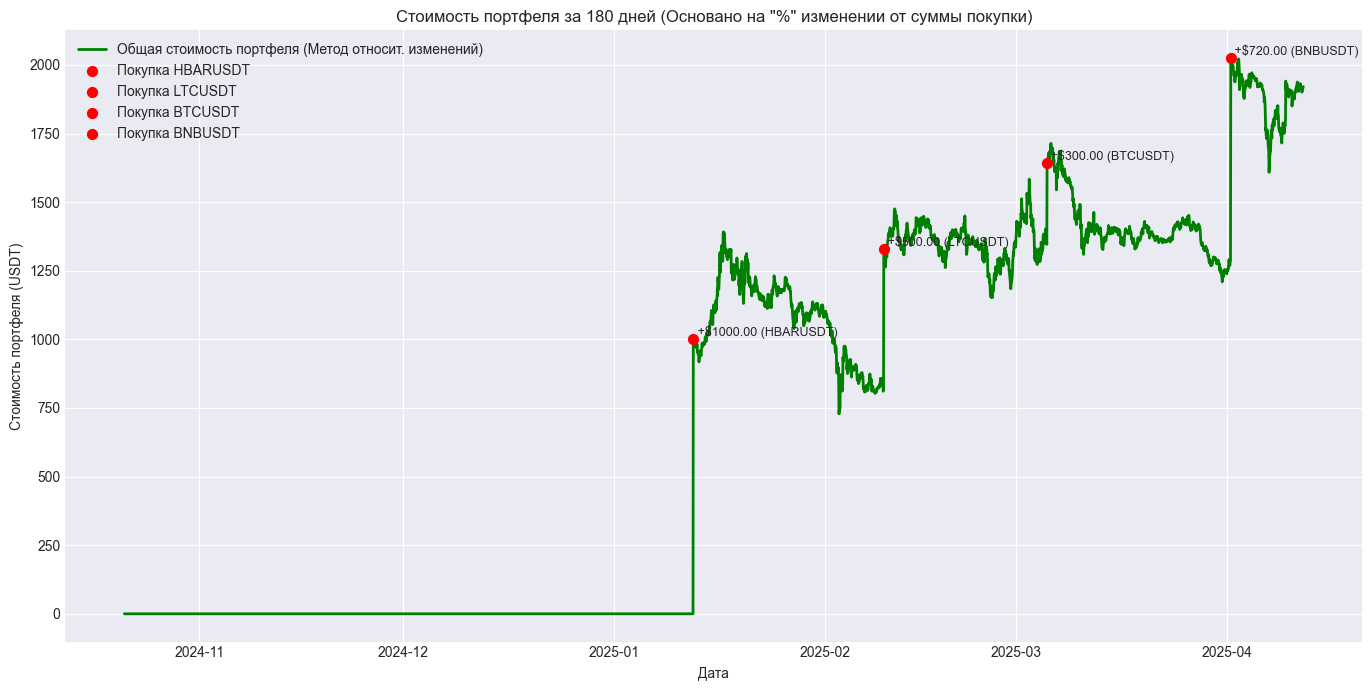


Данные портфеля с найденными ценами покупки:
                 Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
1 2025-02-09 14:21:24   LTCUSDT            500.0              108.02000   
2 2025-03-05 14:21:17   BTCUSDT            300.0            88344.25000   
3 2025-04-01 14:21:01   BNBUSDT            720.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-12 15:00:00  
1        2025-02-09 15:00:00  
2        2025-03-05 15:00:00  
3        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  HBARUSDT_Price  LTCUSDT_Price  \
Open time                                                                  
2025-04-12 03:00:00           1903.455886         0.16620          75.29   
2025-04-12 04:00:00           1910.445666         0.16679          75.83   
2025-04-12 05:00:00           1912.913589         0.16714         

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
portfolio_data = {
    "ID": [3, 2, 1, 0],
    "Дата": ["2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка"], # Не используется
    "Актив": ["HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"], # Нужно для связи с ценами
    "Количество": [4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00], # Не используется
    "Общая стоимость": [1000.00, 500.00, 300.00, 720.00] # КЛЮЧЕВОЙ ПАРАМЕТР
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
# Сортировка ОЧЕНЬ важна для правильной обработки покупок
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')

# Объединение данных по ценам
historical_prices = pd.concat([btc_data, bnb_data, ltc_data, hbar_data], axis=1)

# Определяем временной диапазон
if today is None:
    today = historical_prices.index.max() # Берем последнюю дату из данных
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()
# Используем .copy() чтобы избежать SettingWithCopyWarning

# Заполнение возможных пропусков (важно перед поиском цен покупки)
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN после заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    # Можно либо удалить строки с NaN, либо применить другую стратегию
    historical_prices_filtered = historical_prices_filtered.dropna()

# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Ошибка: Столбец цен {price_col} не найден для актива {asset}.")
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.4f} на {actual_purchase_time_index}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

    else:
        # Если дата покупки позже всех исторических данных, покупку нельзя учесть
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date}. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
# Итерируемся по временным меткам в отфильтрованных данных
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по каждой ДЕЙСТВИТЕЛЬНОЙ покупке в портфеле
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index'] # Фактическое время из индекса цен

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость'] # Берем исходную сумму
            purchase_price = purchase_row['Purchase_Price_Actual'] # Цена в момент покупки
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой конкретной инвестиции
            # на основе ПРОЦЕНТНОГО изменения цены с момента покупки
            if pd.notna(current_price): # Проверяем, что текущая цена действительна
                # Коэффициент изменения цены (Current Price / Purchase Price)
                price_ratio = current_price / purchase_price # purchase_price уже проверена > 0
                current_investment_value = initial_investment * price_ratio
            else:
                # Если текущая цена неизвестна, сохраняем последнюю известную стоимость
                # Найдем предыдущий индекс
                prev_index = historical_prices_filtered.index[historical_prices_filtered.index < current_time_index]
                if not prev_index.empty:
                     # Повторяем расчет для предыдущего индекса (приблизительно)
                     # Это сложная логика, проще считать вклад 0 или оставить как есть
                     prev_price = historical_prices_filtered.loc[prev_index[-1], price_col]
                     if pd.notna(prev_price):
                          price_ratio = prev_price / purchase_price
                          current_investment_value = initial_investment * price_ratio
                     else: # Если и предыдущая цена NaN
                          current_investment_value = 0 # Безопасное значение по умолчанию
                else: # Если это самая первая точка
                     current_investment_value = 0 # Безопасное значение по умолчанию
                print(f"Предупреждение: Отсутствует текущая цена для {asset} на {current_time_index}. Используется приближенное значение.")


            # Добавляем стоимость этой инвестиции к общей стоимости на текущий момент
            current_total_value += current_investment_value

    # Записываем общую стоимость для текущего времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для лучшего вида
plt.figure(figsize=(14, 7))

plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

# Добавим отметки о покупках
unique_labels = set() # Для уникальных меток в легенде
portfolio_in_range = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Ищем точное значение в индексе для корректного отображения
    if plot_time in historical_prices_filtered.index:
        # Стоимость портфеля СРАЗУ ПОСЛЕ добавления этой инвестиции
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text = f'Покупка {row["Актив"]}'
        # Добавляем метку в легенду только один раз для каждого типа события
        current_label = label_text if label_text not in unique_labels else ""
        if current_label: unique_labels.add(label_text)

        plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label) # s - размер точки
        # Текст с названием актива и суммой покупки
        plt.text(plot_time + pd.Timedelta(hours=1), value_at_purchase, # Смещаем текст чуть вправо
                 f" +${row['Общая стоимость']:.2f} ({row['Актив']})",
                 fontsize=9, verticalalignment='bottom', horizontalalignment='left')
    else:
         # Это не должно происходить, если проверка на NaN была успешной
         print(f"Предупреждение: Не удалось найти индекс {plot_time} для отметки покупки {row['Актив']}")


plt.title(f'Стоимость портфеля за {days_history} дней (Основано на "%" изменении от суммы покупки)')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

# Создаем легенду, избегая дубликатов
handles, labels = plt.gca().get_legend_handles_labels()
# Убираем дубликаты, сохраняя порядок
from collections import OrderedDict
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout() # Улучшает размещение элементов
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами покупки:")
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']])

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Показываем итоговую стоимость и цены активов для сравнения
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail())

print(f"\nРассчитанные данные портфеля (первые 5 записей):")
print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head())

Поиск цен на момент покупки...

Учтено покупок после поиска цен: 5
Расчет относительной стоимости портфеля...
Расчет завершен.


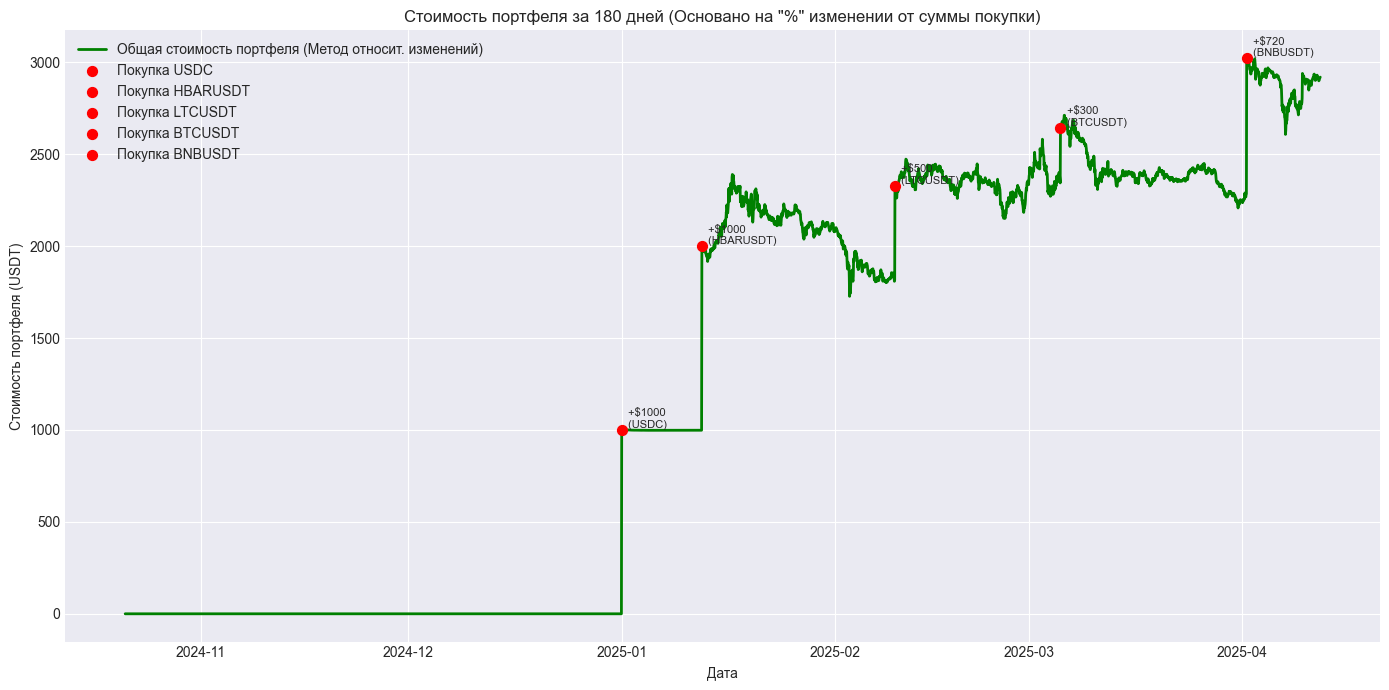


Данные портфеля с найденными ценами покупки:
                 Дата     Актив  Общая стоимость  Purchase_Price_Actual  \
0 2025-01-01 00:00:00      USDC           1000.0                1.00190   
1 2025-01-12 14:29:48  HBARUSDT           1000.0                0.28239   
2 2025-02-09 14:21:24   LTCUSDT            500.0              108.02000   
3 2025-03-05 14:21:17   BTCUSDT            300.0            88344.25000   
4 2025-04-01 14:21:01   BNBUSDT            720.0              615.26000   

  Actual_Purchase_Time_Index  
0        2025-01-01 00:00:00  
1        2025-01-12 15:00:00  
2        2025-02-09 15:00:00  
3        2025-03-05 15:00:00  
4        2025-04-01 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  USDC_Price  HBARUSDT_Price  \
Open time                                                               
2025-04-12 03:00:00           2902.058541      1.0005         0.16620   
2025-04-12 04:00:00           2908.948511    

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# Данные портфеля остаются теми же, с добавленным USDC
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00, 500.00, 300.00, 720.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # *** Загружаем данные для USDC ***
    usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    # Проверяем наличие нужных столбцов
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        # Можно вернуть пустой DataFrame или вызвать исключение
        return pd.DataFrame() # Возвращаем пустой DataFrame

    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    # Нам нужен только столбец Close для цен
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    # Явно указываем тип float
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
# *** Предобрабатываем данные USDC ***
# Используем 'USDC' в качестве asset_name, чтобы получить столбец 'USDC_Price'
usdc_data = preprocess_data(usdc_data, 'USDC')

# Проверяем, что все DataFrame не пустые после предобработки
data_frames = {'BTC': btc_data, 'BNB': bnb_data, 'LTC': ltc_data, 'HBAR': hbar_data, 'USDC': usdc_data}
valid_data_frames = [df for name, df in data_frames.items() if not df.empty]

if len(valid_data_frames) < len(data_frames):
    print("Предупреждение: Не все файлы данных удалось успешно обработать.")
    # Решаем, продолжать ли с неполными данными или остановиться
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")


# Объединение данных по ценам
# *** Включаем usdc_data в объединение ***
historical_prices = pd.concat(valid_data_frames, axis=1)

# --- УДАЛЕНО: Строка historical_prices['USDC_Price'] = 1.0 больше не нужна ---

# Определяем временной диапазон
if today is None:
    if historical_prices.empty:
         print("Ошибка: Невозможно определить 'today', т.к. нет исторических данных.")
         exit()
    # Берем последнюю дату из ВСЕХ объединенных данных
    today = historical_prices.index.max()

start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

# Фильтрация объединенных данных по заданному ИСТОРИЧЕСКОМУ диапазону
historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()

# Проверка, что после фильтрации остались данные
if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()

# Заполнение возможных пропусков (важно перед поиском цен покупки)
# Теперь это применится и к реальным данным USDC
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверка на наличие NaN после заполнения
# Особенно важно для USDC, если в файле были пропуски
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    # Удаляем строки с оставшимися NaN, чтобы избежать ошибок при расчетах
    print("Удаление строк с NaN...")
    historical_prices_filtered = historical_prices_filtered.dropna()
    if historical_prices_filtered.empty:
        print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
        exit()


# Добавляем столбцы для хранения цены покупки и индекса времени для каждой транзакции
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

# Находим фактическую цену в исторических данных НА МОМЕНТ ПОКУПКИ или сразу после
print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    # Проверяем, есть ли вообще столбец цен для этого актива (после concat и dropna)
    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Столбец цен {price_col} для актива {asset} отсутствует в отфильтрованных данных. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT # Помечаем как недействительное
        continue # Пропускаем эту покупку

    # Ищем первый индекс времени в historical_prices_filtered >= даты покупки
    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        # *** Теперь цена USDC будет взята из загруженного файла ***
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        # Проверка, что цена не NaN и не 0
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Для {asset} ({purchase_date}): Найдена цена {purchase_price:.6f} на {actual_purchase_time_index}") # Увеличил точность для USDC
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

    else:
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

# Удаляем строки из портфеля, для которых не удалось найти действительное время/цену покупки
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Инициализируем столбец общей стоимости нулями
historical_prices_filtered['Total_Value_Relative'] = 0.0

# Рассчитываем стоимость для каждого момента времени
print("Расчет относительной стоимости портфеля...")
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Проверяем наличие столбца перед доступом (на всякий случай, хотя не должно быть проблемой после проверки выше)
            if price_col not in historical_prices_filtered.columns:
                continue

            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            if pd.notna(current_price) and purchase_price > 0: # Добавил проверку purchase_price > 0 здесь на всякий случай
                # *** Расчет для USDC теперь будет использовать реальные исторические цены ***
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                # Логика обработки NaN для текущей цены (менее вероятна после dropna, но оставим)
                 current_investment_value = 0 # Безопаснее просто обнулить вклад, если цена пропала
                 if pd.isna(current_price):
                     print(f"Предупреждение: Отсутствует текущая цена для {asset} на {current_time_index} после заполнения/очистки. Вклад = 0.")
                 elif purchase_price <= 0:
                      print(f"Предупреждение: Некорректная цена покупки ({purchase_price}) для {asset}. Вклад = 0.")


            current_total_value += current_investment_value

    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value

print("Расчет завершен.")

# --- Шаг 4: Визуализация ---
# Код визуализации остается без изменений, он будет использовать рассчитанные значения
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 7))

plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Общая стоимость портфеля (Метод относит. изменений)', color='green', linewidth=2)

unique_labels = set()
portfolio_in_range = portfolio_df[
    (portfolio_df['Actual_Purchase_Time_Index'] >= start_date_history) &
    (portfolio_df['Actual_Purchase_Time_Index'] <= today)
]

for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    if plot_time in historical_prices_filtered.index:
        value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
        label_text = f'Покупка {row["Актив"]}'
        current_label = label_text if label_text not in unique_labels else ""
        if current_label: unique_labels.add(label_text)
        plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label)
        plt.text(plot_time + pd.Timedelta(hours=12), value_at_purchase,
                 f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
                 fontsize=8, verticalalignment='bottom', horizontalalignment='left')
    else:
         nearest_index = historical_prices_filtered.index.asof(plot_time)
         if nearest_index is not pd.NaT and nearest_index >= start_date_history: # Добавил проверку >= start_date_history
             print(f"Предупреждение: Точный индекс {plot_time} не найден для {row['Актив']}. Используется ближайший {nearest_index}.")
             value_at_purchase = historical_prices_filtered.loc[nearest_index, 'Total_Value_Relative']
             label_text = f'Покупка {row["Актив"]}'
             current_label = label_text if label_text not in unique_labels else ""
             if current_label: unique_labels.add(label_text)
             plt.scatter(nearest_index, value_at_purchase, color='red', s=50, zorder=5, label=current_label)
             plt.text(nearest_index + pd.Timedelta(hours=12), value_at_purchase,
                  f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
                  fontsize=8, verticalalignment='bottom', horizontalalignment='left')
         else:
             print(f"Критическое предупреждение: Не удалось найти подходящий индекс для {plot_time} ({row['Актив']}). Отметка не добавлена.")


plt.title(f'Стоимость портфеля за {days_history} дней (Основано на "%" изменении от суммы покупки)')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

from collections import OrderedDict
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()

# Вывод данных для проверки
print("\nДанные портфеля с найденными ценами покупки:")
# Используем .round(6) для лучшего отображения цены USDC
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6}))


print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
if price_cols_to_show:
    print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].tail().round(6))
else:
    print("Нет доступных колонок с ценами для отображения.")


print(f"\nРассчитанные данные портфеля (первые 5 записей):")
if price_cols_to_show:
    print(historical_prices_filtered[['Total_Value_Relative'] + price_cols_to_show].head().round(6))
else:
     print("Нет доступных колонок с ценами для отображения.")

Ошибка: В файле для BNBUSDT отсутствуют столбцы 'Open time' или 'Close'.
Ошибка: В файле для LTCUSDT отсутствуют столбцы 'Open time' или 'Close'.
Ошибка: В файле для HBARUSDT отсутствуют столбцы 'Open time' или 'Close'.
Предупреждение: Не все файлы данных удалось успешно обработать.
Продолжение работы с доступными данными...
Поиск цен на момент покупки...
Предупреждение: Столбец цен HBARUSDT_Price для актива HBARUSDT отсутствует в отфильтрованных данных. Покупка будет проигнорирована.
Предупреждение: Столбец цен LTCUSDT_Price для актива LTCUSDT отсутствует в отфильтрованных данных. Покупка будет проигнорирована.
Предупреждение: Столбец цен BNBUSDT_Price для актива BNBUSDT отсутствует в отфильтрованных данных. Покупка будет проигнорирована.

Учтено покупок после поиска цен: 2
Расчет относительной стоимости портфеля (Стратегия 1)...
Расчет Стратегии 1 завершен.
Расчет стоимости с идеальной ребалансировкой (Стратегия 2)...
Расчет Стратегии 2 завершен.


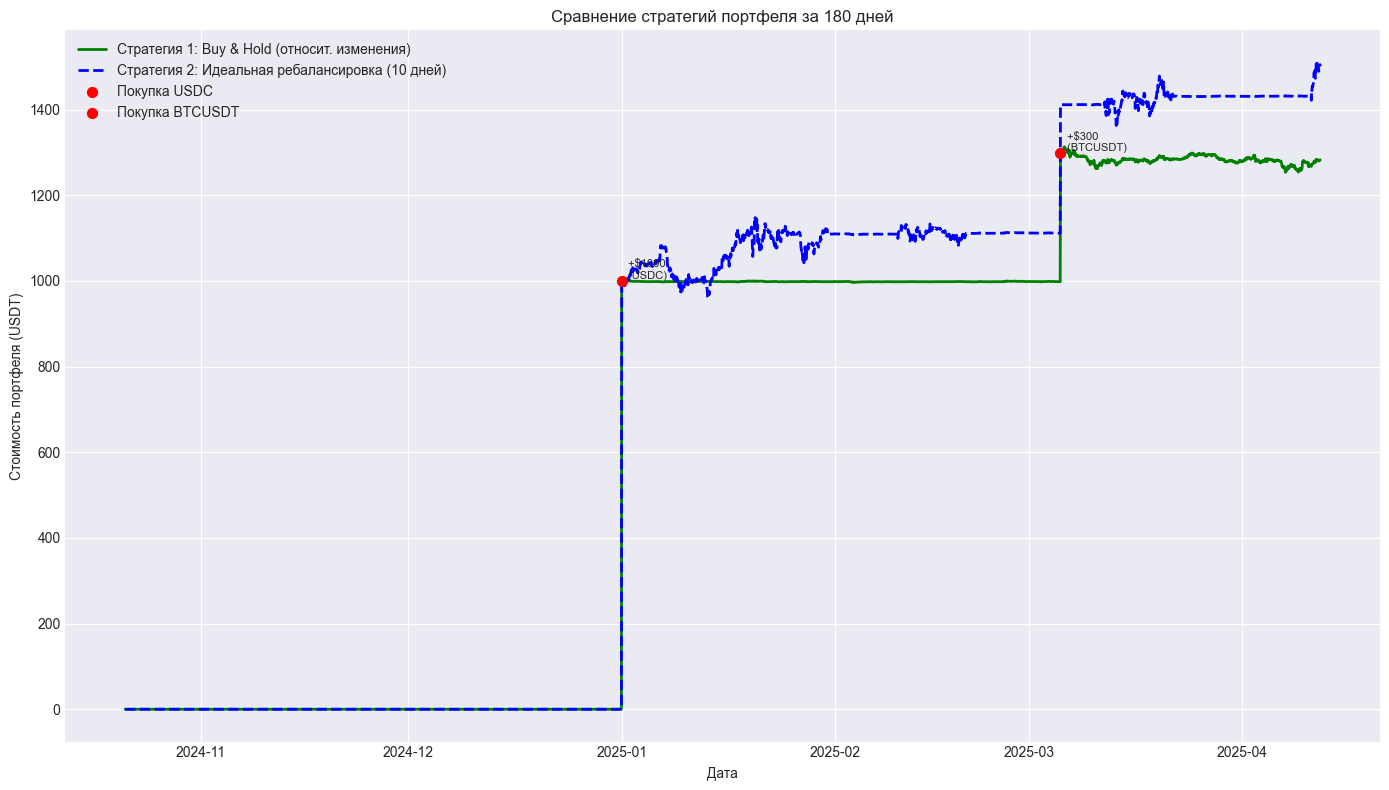


Данные портфеля с найденными ценами покупки:
                 Дата    Актив  Общая стоимость  Purchase_Price_Actual  \
0 2025-01-01 00:00:00     USDC           1000.0                 1.0019   
3 2025-03-05 14:21:17  BTCUSDT            300.0             88344.2500   

  Actual_Purchase_Time_Index  
0        2025-01-01 00:00:00  
3        2025-03-05 15:00:00  

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               1280.36              1492.23   
2025-04-12 04:00:00               1281.06              1496.46   
2025-04-12 05:00:00               1281.61              1498.81   
2025-04-12 06:00:00               1282.64              1504.83   
2025-04-12 07:00:00               1282.30              1502.48   

                    Held_Asset_Perfect  USDC_Price  BTCUSDT_Price  
Open time                                             

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 10 # <-- Интервал ребалансировки

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# Данные портфеля остаются теми же, с добавленным USDC
portfolio_data = {
    "ID": [4, 3, 2, 1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000", "2025-02-09T14:21:24.000", "2025-03-05T14:21:17.000", "2025-04-01T14:21:01.000"],
    "Тип": ["Покупка", "Покупка", "Покупка", "Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT", "LTCUSDT", "BTCUSDT", "BNBUSDT"],
    "Количество": [1000.0, 4667.50014884, 131.38877940, 0.01195125, 1.70157736], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17, 76.11, 83.26, 58.69], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00, 0.00, 0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00, 500.00, 300.00, 720.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    btc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BTCUSDT_hourly_data.csv')
    # bnb_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\BNBUSDT_hourly_data.csv')
    # ltc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\LTCUSDT_hourly_data.csv')
    # hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    # # *** Загружаем данные для USDC ***
    usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()

def preprocess_data(df, asset_name):
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        return pd.DataFrame()

    df['Open time'] = pd.to_datetime(df['Open time'])
    df = df.set_index('Open time')
    df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
    df[f'{asset_name}_Price'] = df[f'{asset_name}_Price'].astype(float)
    return df

btc_data = preprocess_data(btc_data, 'BTCUSDT')
bnb_data = preprocess_data(bnb_data, 'BNBUSDT')
ltc_data = preprocess_data(ltc_data, 'LTCUSDT')
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
usdc_data = preprocess_data(usdc_data, 'USDC') # Используем 'USDC' для 'USDC_Price'

data_frames = {'BTC': btc_data, 'BNB': bnb_data, 'LTC': ltc_data, 'HBAR': hbar_data, 'USDC': usdc_data}
valid_data_frames = [df for name, df in data_frames.items() if not df.empty]

if len(valid_data_frames) < len(data_frames):
    print("Предупреждение: Не все файлы данных удалось успешно обработать.")
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")


historical_prices = pd.concat(valid_data_frames, axis=1)

if today is None:
    if historical_prices.empty:
         print("Ошибка: Невозможно определить 'today', т.к. нет исторических данных.")
         exit()
    today = historical_prices.index.max()

start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости (Метод относительных изменений) ---

historical_prices_filtered = historical_prices[(historical_prices.index >= start_date_history) & (historical_prices.index <= today)].copy()

if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()

historical_prices_filtered = historical_prices_filtered.ffill().bfill()

if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    print("Удаление строк с NaN...")
    historical_prices_filtered = historical_prices_filtered.dropna()
    if historical_prices_filtered.empty:
        print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
        exit()


portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("Поиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price'

    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Столбец цен {price_col} для актива {asset} отсутствует в отфильтрованных данных. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT
        continue

    relevant_prices = historical_prices_filtered[historical_prices_filtered.index >= purchase_date]

    if not relevant_prices.empty:
        actual_purchase_time_index = relevant_prices.index[0]
        purchase_price = relevant_prices.loc[actual_purchase_time_index, price_col]

        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index}. Покупка будет проигнорирована.")
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

    else:
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")
        portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = pd.NaT

portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)

print(f"\nУчтено покупок после поиска цен: {len(portfolio_df)}")
if len(portfolio_df) == 0:
      print("Ошибка: Не найдено действительных покупок для анализа. Проверьте даты и наличие данных.")
      exit()

# Расчет стоимости по методу относительных изменений (Стратегия 1)
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("Расчет относительной стоимости портфеля (Стратегия 1)...")
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            if price_col not in historical_prices_filtered.columns:
                continue

            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            if pd.notna(current_price) and purchase_price > 0:
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                 current_investment_value = 0
                 # Опционально: добавить предупреждения, если нужно
            current_total_value += current_investment_value

    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value
print("Расчет Стратегии 1 завершен.")


# --- Шаг 3.5: Расчет стоимости с идеальной ребалансировкой (Стратегия 2) ---
print("Расчет стоимости с идеальной ребалансировкой (Стратегия 2)...")

# Инициализация
historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = '' # Какой актив "держим"
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None # Колонка цены актива, который держим

# Определяем время начала симуляции - время первой покупки
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()

# Получаем список колонок с ценами активов
asset_price_cols = [col for col in historical_prices_filtered.columns if col.endswith('_Price')]

# Создаем словарь для быстрого доступа к суммам пополнений по датам
investments_by_time = portfolio_df.set_index('Actual_Purchase_Time_Index')['Общая стоимость'].to_dict()

# Итерация по временным точкам, начиная с первой покупки
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step = True

for current_time in sim_data.index:
    # 1. Добавляем новые инвестиции, если они есть в эту временную точку
    if current_time in investments_by_time:
        current_perfect_value += investments_by_time[current_time]
        # Если это самая первая инвестиция, нужно инициализировать last_rebalance_time
        if pd.isna(last_rebalance_time):
             last_rebalance_time = current_time # Начинаем первый период ребалансировки


    # 2. Логика ребалансировки: решаем, какой актив держать СЛЕДУЮЩИЕ 7 дней
    # Ребалансировка происходит:
    # - В самый первый момент времени симуляции (после возможного первого пополнения)
    # - Когда проходит rebalance_interval_days с момента последней ребалансировки
    if first_step or (not pd.isna(last_rebalance_time) and current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days)):

        lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days)
        # Убедимся, что не выходим за пределы данных
        lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
        # Найдем ближайший доступный индекс к lookahead_end_time
        actual_lookahead_index = sim_data.index.asof(lookahead_end_time)

        best_future_return = -np.inf
        best_asset_col_for_future = None

        # Оцениваем будущую доходность каждого актива
        if actual_lookahead_index > current_time: # Только если есть период для оценки
            for asset_col in asset_price_cols:
                price_now = sim_data.loc[current_time, asset_col]
                price_future = sim_data.loc[actual_lookahead_index, asset_col]

                if pd.notna(price_now) and price_now > 0 and pd.notna(price_future):
                    future_return = price_future / price_now
                    if future_return > best_future_return:
                        best_future_return = future_return
                        best_asset_col_for_future = asset_col
                #else:
                #    print(f"Debug: Skipping {asset_col} at {current_time} due to invalid prices (now={price_now}, future={price_future})")


        if best_asset_col_for_future:
            held_asset_perfect_col = best_asset_col_for_future
            last_rebalance_time = current_time # Запоминаем время ребалансировки
            # print(f"Debug Rebalance at {current_time}: Chose {held_asset_perfect_col} for next {rebalance_interval_days} days (until ~{lookahead_end_time})")
        #else:
            # print(f"Debug Rebalance at {current_time}: Could not determine best asset. Holding previous: {held_asset_perfect_col}")
            # Если не удалось выбрать лучший (например, конец данных), продолжаем держать старый
            pass


    # 3. Рассчитываем изменение стоимости портфеля за текущий шаг (час)
    # Это происходит ПОСЛЕ возможного пополнения и ПОСЛЕ решения о ребалансировке
    if not first_step and held_asset_perfect_col and current_perfect_value > 0:
        previous_time = sim_data.index[sim_data.index.get_loc(current_time) - 1]

        current_price = sim_data.loc[current_time, held_asset_perfect_col]
        previous_price = sim_data.loc[previous_time, held_asset_perfect_col]

        if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
             price_ratio_step = current_price / previous_price
             current_perfect_value *= price_ratio_step
        # else: # Если цена пропала, стоимость не меняется за этот шаг
             # print(f"Warning: Missing price for {held_asset_perfect_col} between {previous_time} and {current_time}. Value held constant.")
             pass

    # 4. Сохраняем текущую стоимость и какой актив держим
    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col:
        historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = held_asset_perfect_col.replace('_Price', '') # Сохраняем чистое имя актива

    first_step = False # Снимаем флаг первого шага

print("Расчет Стратегии 2 завершен.")

# --- Шаг 4: Визуализация ---
plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 8)) # Немного увеличим высоту для легенды

# График 1: Относительные изменения (Buy & Hold с момента покупки)
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (относит. изменения)', color='green', linewidth=2)

# График 2: Идеальная ребалансировка
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=f'Стратегия 2: Идеальная ребалансировка ({rebalance_interval_days} дней)', color='blue', linewidth=2, linestyle='--')


# Отметки о покупках (остаются те же, относятся к обеим стратегиям как точки вливания капитала)
unique_labels = set()
# Фильтруем покупки, чтобы они попадали в отображаемый диапазон И были учтены (не отброшены ранее)
portfolio_in_range = portfolio_df[
    portfolio_df['Actual_Purchase_Time_Index'].isin(historical_prices_filtered.index)
]

# Рисуем отметки на графике Стратегии 1 (можно и на втором, но будет менее читаемо)
for index, row in portfolio_in_range.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Берем значение из стратегии 1 для позиционирования отметки
    value_at_purchase = historical_prices_filtered.loc[plot_time, 'Total_Value_Relative']
    label_text = f'Покупка {row["Актив"]}'
    current_label = label_text if label_text not in unique_labels else ""
    if current_label: unique_labels.add(label_text)
    # Рисуем на кривой Стратегии 1
    plt.scatter(plot_time, value_at_purchase, color='red', s=50, zorder=5, label=current_label)
    # Добавляем текст рядом с точкой
    plt.text(plot_time + pd.Timedelta(hours=12), value_at_purchase,
             f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
             fontsize=8, verticalalignment='bottom', horizontalalignment='left')

plt.title(f'Сравнение стратегий портфеля за {days_history} дней')
plt.xlabel('Дата')
plt.ylabel('Стоимость портфеля (USDT)')
plt.grid(True)

# Используем OrderedDict для сохранения порядка в легенде
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left') # Позиция легенды

plt.tight_layout()
plt.show()

# --- Вывод данных для проверки ---
print("\nДанные портфеля с найденными ценами покупки:")
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']].round({'Purchase_Price_Actual': 6}))


print(f"\nРассчитанные данные портфеля (последние 5 записей):")
# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = [f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns]
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect'] + price_cols_to_show
# Округляем только числовые колонки
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
print(historical_prices_filtered[cols_to_show].tail().round({col: 2 for col in numeric_cols if 'Price' not in col} | {col: 6 for col in numeric_cols if 'Price' in col}))


print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки):")
print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round({col: 2 for col in numeric_cols if 'Price' not in col} | {col: 6 for col in numeric_cols if 'Price' in col}))

# Дополнительная проверка: Какие активы выбирались для идеальной стратегии
print("\nАктивы, выбираемые идеальной стратегией (примеры):")
print(historical_prices_filtered[historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()][['Total_Value_Perfect', 'Held_Asset_Perfect']].dropna(subset=['Held_Asset_Perfect']))


Поиск цен на момент покупки...
Поиск цен завершен. Учтено покупок: 2 из 2.

Расчет относительной стоимости портфеля (Стратегия 1)...
Расчет Стратегии 1 завершен.

Расчет стоимости с идеальной ребалансировкой (Стратегия 2)...
Расчет Стратегии 2 завершен.

Подготовка графика...


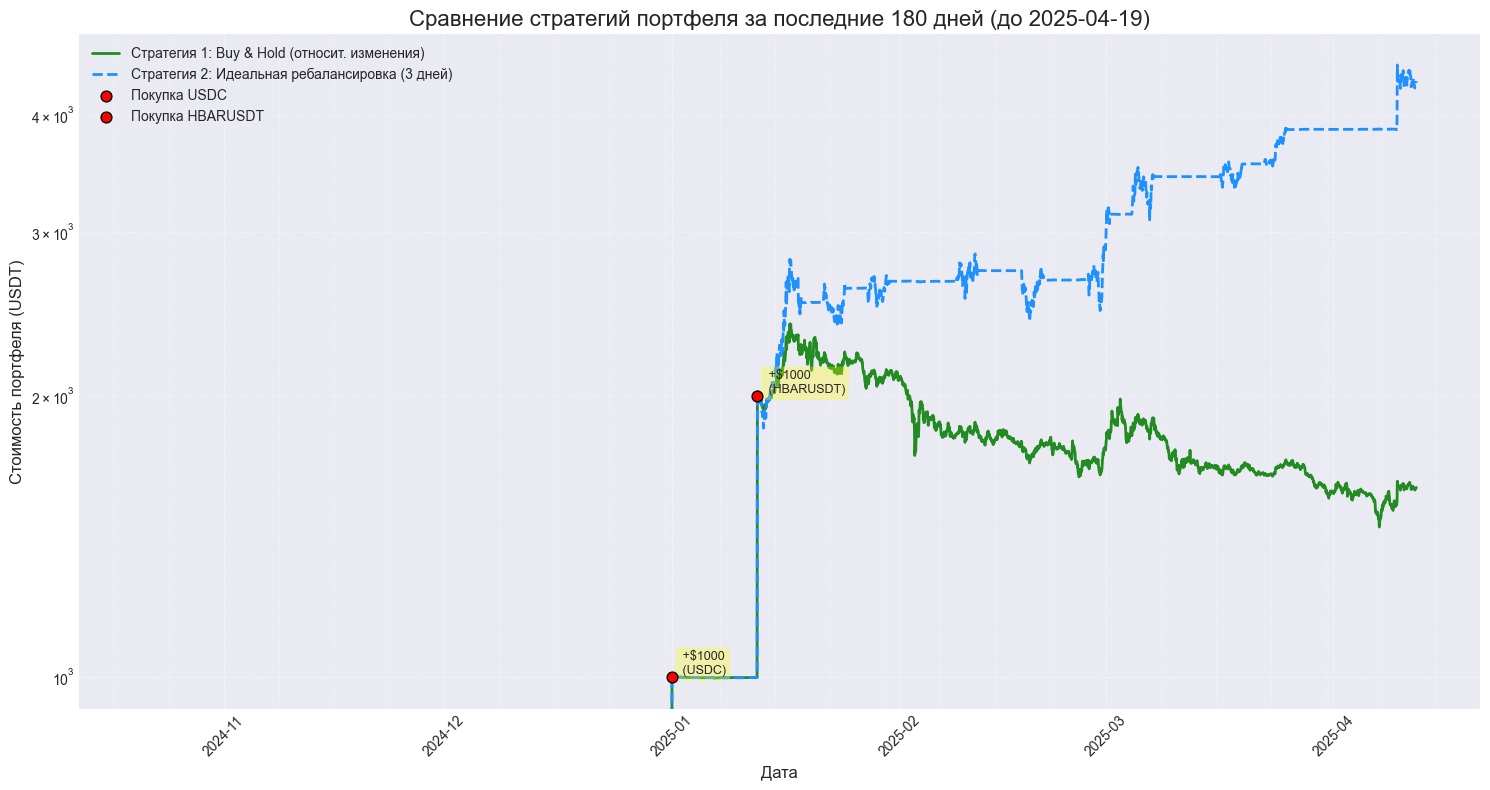


--- Результаты ---

Данные портфеля с найденными ценами и временем покупки:
               Дата    Актив  Общая стоимость  Purchase_Price_Actual Actual_Purchase_Time_Index
2025-01-01 00:00:00     USDC           1000.0                1.00190        2025-01-01 00:00:00
2025-01-12 14:29:48 HBARUSDT           1000.0                0.28239        2025-01-12 15:00:00

Рассчитанные данные портфеля (последние 5 записей):
                     Total_Value_Relative  Total_Value_Perfect  \
Open time                                                        
2025-04-12 03:00:00               1587.15              4282.57   
2025-04-12 04:00:00               1589.14              4297.78   
2025-04-12 05:00:00               1590.48              4306.79   
2025-04-12 06:00:00               1593.32              4328.18   
2025-04-12 07:00:00               1596.18              4348.28   

                    Held_Asset_Perfect  HBARUSDT_Price  USDC_Price  
Open time                                         

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict # Import OrderedDict

# --- Настройки ---
days_history = 180
# Укажите "сегодняшнюю" дату для отсчета истории назад
today = pd.Timestamp('2025-04-19')
# Либо, если ваши CSV обновляются, можно брать последнюю дату из данных:
# today = None # Раскомментируйте, если хотите использовать последнюю дату из данных
rebalance_interval_days = 3 # <-- Интервал ребалансировки

# --- Шаг 1: Загрузка данных о портфеле (используем только Дату, Актив, Общую стоимость) ---
# Данные портфеля остаются теми же, с добавленным USDC
portfolio_data = {
    "ID": [1, 0],
    "Дата": ["2025-01-01T00:00:00.000", "2025-01-12T14:29:48.000"],
    "Тип": ["Покупка", "Покупка"],
    "Актив": ["USDC", "HBARUSDT"],
    "Количество": [1000.0, 4667.50014884], # НЕ ИСПОЛЬЗУЕТСЯ
    "Цена": [1.0, 0.17], # НЕ ИСПОЛЬЗУЕТСЯ
    "Комиссия": [0.00, 0.00],
    "Общая стоимость": [1000.00, 1000.00]
}
portfolio_df = pd.DataFrame(portfolio_data)
portfolio_df['Дата'] = pd.to_datetime(portfolio_df['Дата'])
portfolio_df = portfolio_df.sort_values(by='Дата').reset_index(drop=True)

# --- Шаг 2: Загрузка исторических данных активов ---
try:
    # Укажите ПРАВИЛЬНЫЕ пути к вашим файлам CSV
    # !!! Замените 'D:\\path\\to\\your\\data' на реальные пути !!!
    hbar_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\HBARUSDT_hourly_data.csv')
    usdc_data = pd.read_csv('D:\\__projects__\\diploma\\portfolios-optimization\\data\\USDCUSDT_hourly_data.csv')
except FileNotFoundError as e:
    print(f"Ошибка: Файл не найден. Проверьте путь: {e}")
    exit()
except Exception as e:
    print(f"Ошибка при чтении CSV файла: {e}")
    exit()

def preprocess_data(df, asset_name):
    """Преобразует DataFrame с историческими данными."""
    if 'Open time' not in df.columns or 'Close' not in df.columns:
        print(f"Ошибка: В файле для {asset_name} отсутствуют столбцы 'Open time' или 'Close'.")
        return pd.DataFrame() # Возвращаем пустой DataFrame при ошибке

    try:
        df['Open time'] = pd.to_datetime(df['Open time'])
        df = df.set_index('Open time')
        # Выбираем и переименовываем столбец Close
        df = df[['Close']].rename(columns={'Close': f'{asset_name}_Price'})
        # Преобразуем в числовой тип, обрабатывая возможные ошибки
        df[f'{asset_name}_Price'] = pd.to_numeric(df[f'{asset_name}_Price'], errors='coerce')
        # Удаляем строки, где цена не смогла преобразоваться в число
        df.dropna(subset=[f'{asset_name}_Price'], inplace=True)
        return df
    except Exception as e:
        print(f"Ошибка при обработке данных для {asset_name}: {e}")
        return pd.DataFrame()

# Обрабатываем данные для каждого актива
hbar_data = preprocess_data(hbar_data, 'HBARUSDT')
usdc_data = preprocess_data(usdc_data, 'USDC') # Предполагаем, что для USDC актив называется 'USDC'

# Собираем успешно обработанные данные
data_frames = {'HBARUSDT': hbar_data, 'USDC': usdc_data} # Используем имена активов из portfolio_df
valid_data_frames = {name: df for name, df in data_frames.items() if not df.empty}

if len(valid_data_frames) < len(data_frames):
    print("Предупреждение: Не все файлы данных удалось успешно обработать.")
    if not valid_data_frames:
        print("Ошибка: Ни один файл данных не был успешно обработан. Выход.")
        exit()
    print("Продолжение работы с доступными данными...")

# Объединяем данные в один DataFrame
if not valid_data_frames:
      print("Ошибка: Нет данных для объединения.")
      exit()

historical_prices = pd.concat(valid_data_frames.values(), axis=1) # values() т.к. ключи уже не нужны для concat

# Определяем 'today', если не задано вручную
if today is None:
    if historical_prices.empty or historical_prices.index.max() is pd.NaT:
         print("Ошибка: Невозможно определить 'today', т.к. нет валидных исторических данных.")
         exit()
    today = historical_prices.index.max()
    print(f"Используется последняя дата из данных: {today}")

# Определяем дату начала истории
start_date_history = today - pd.Timedelta(days=days_history)

# --- Шаг 3: Фильтрация, подготовка и расчет стоимости ---

# Фильтруем исторические данные по дате
historical_prices_filtered = historical_prices[
    (historical_prices.index >= start_date_history) &
    (historical_prices.index <= today)
].copy() # Используем .copy() для избежания SettingWithCopyWarning

if historical_prices_filtered.empty:
    print(f"Ошибка: Нет исторических данных в диапазоне от {start_date_history} до {today}. Проверьте даты или файлы.")
    exit()

# Заполняем пропуски (если есть) сначала предыдущим значением, потом следующим
historical_prices_filtered = historical_prices_filtered.ffill().bfill()

# Проверяем наличие NaN после заполнения
if historical_prices_filtered.isnull().values.any():
    print("Предупреждение: В исторических данных остались пропуски (NaN) после заполнения.")
    print(historical_prices_filtered[historical_prices_filtered.isnull().any(axis=1)])
    print("Удаление строк с NaN...")
    rows_before = len(historical_prices_filtered)
    historical_prices_filtered = historical_prices_filtered.dropna()
    print(f"Удалено {rows_before - len(historical_prices_filtered)} строк.")
    if historical_prices_filtered.empty:
        print("Ошибка: Все данные были удалены после обработки NaN. Проверьте исходные файлы.")
        exit()

# --- Привязка покупок к историческим данным ---
portfolio_df['Purchase_Price_Actual'] = np.nan
portfolio_df['Actual_Purchase_Time_Index'] = pd.NaT

print("\nПоиск цен на момент покупки...")
for index, row in portfolio_df.iterrows():
    asset = row['Актив']
    purchase_date = row['Дата']
    price_col = f'{asset}_Price' # Формируем имя колонки

    # Проверяем, существует ли колонка цен для этого актива в отфильтрованных данных
    if price_col not in historical_prices_filtered.columns:
        print(f"Предупреждение: Столбец цен '{price_col}' для актива '{asset}' отсутствует в отфильтрованных данных. Покупка будет проигнорирована.")
        continue # Переходим к следующей покупке

    # Ищем первую временную метку в истории >= дате покупки
    # Используем asof для поиска ближайшей метки *до* или *в* указанное время,
    # но нам нужна >=, поэтому ищем в срезе и берем первую
    relevant_times = historical_prices_filtered.index[historical_prices_filtered.index >= purchase_date]

    if not relevant_times.empty:
        actual_purchase_time_index = relevant_times[0]
        # Получаем цену в эту временную точку
        purchase_price = historical_prices_filtered.loc[actual_purchase_time_index, price_col]

        # Проверяем валидность цены
        if pd.notna(purchase_price) and purchase_price > 0:
            portfolio_df.loc[index, 'Purchase_Price_Actual'] = purchase_price
            portfolio_df.loc[index, 'Actual_Purchase_Time_Index'] = actual_purchase_time_index
            # print(f"  Найдено для {asset} на {purchase_date}: время {actual_purchase_time_index}, цена {purchase_price:.6f}")
        else:
            print(f"Предупреждение: Найдена некорректная цена ({purchase_price}) для {asset} на {actual_purchase_time_index} (запрос был на {purchase_date}). Покупка будет проигнорирована.")
    else:
        # Если нет данных >= даты покупки в нашем временном окне
        print(f"Предупреждение: Не найдены исторические данные для {asset} на или после {purchase_date} в диапазоне [{start_date_history}, {today}]. Покупка будет проигнорирована.")

# Удаляем строки из портфеля, для которых не удалось найти цену или время
initial_purchases_count = len(portfolio_df)
portfolio_df.dropna(subset=['Actual_Purchase_Time_Index', 'Purchase_Price_Actual'], inplace=True)
final_purchases_count = len(portfolio_df)
print(f"Поиск цен завершен. Учтено покупок: {final_purchases_count} из {initial_purchases_count}.")

if final_purchases_count == 0:
      print("\nОшибка: Не найдено действительных покупок для анализа после проверки цен. Проверьте даты покупок и наличие исторических данных в указанном диапазоне.")
      exit()

# --- Расчет Стратегии 1: Buy & Hold (Относительные изменения) ---
historical_prices_filtered['Total_Value_Relative'] = 0.0
print("\nРасчет относительной стоимости портфеля (Стратегия 1)...")

# Итерируемся по временным точкам истории
for current_time_index in historical_prices_filtered.index:
    current_total_value = 0.0
    # Итерируемся по УЧТЕННЫМ покупкам
    for _, purchase_row in portfolio_df.iterrows():
        purchase_time_index = purchase_row['Actual_Purchase_Time_Index']

        # Учитываем покупку только если текущее время >= времени покупки
        if current_time_index >= purchase_time_index:
            initial_investment = purchase_row['Общая стоимость']
            purchase_price = purchase_row['Purchase_Price_Actual']
            asset = purchase_row['Актив']
            price_col = f'{asset}_Price'

            # Получаем текущую цену актива (уже проверили, что колонка существует при поиске цен)
            current_price = historical_prices_filtered.loc[current_time_index, price_col]

            # Рассчитываем текущую стоимость этой части инвестиции
            if pd.notna(current_price) and purchase_price > 0:
                price_ratio = current_price / purchase_price
                current_investment_value = initial_investment * price_ratio
            else:
                 # Если текущая цена некорректна, считаем стоимость этой части нулевой
                 current_investment_value = 0
                 # Можно добавить предупреждение, если это происходит часто
                 # print(f"Warning: Invalid current price {current_price} for {asset} at {current_time_index}")

            current_total_value += current_investment_value

    # Записываем общую стоимость портфеля на данный момент времени
    historical_prices_filtered.loc[current_time_index, 'Total_Value_Relative'] = current_total_value
print("Расчет Стратегии 1 завершен.")


# --- Расчет Стратегии 2: Идеальная ребалансировка (с учетом купленных активов и ребалансировкой при пополнении) ---
print("\nРасчет стоимости с идеальной ребалансировкой (Стратегия 2)...")

# Инициализация
historical_prices_filtered['Total_Value_Perfect'] = 0.0
historical_prices_filtered['Held_Asset_Perfect'] = '' # Какой актив "держим"
current_perfect_value = 0.0
last_rebalance_time = pd.NaT
held_asset_perfect_col = None # Колонка цены актива, который держим

# Определяем время начала симуляции - время самой первой УЧТЕННОЙ покупки
first_investment_time = portfolio_df['Actual_Purchase_Time_Index'].min()
if pd.isna(first_investment_time):
    print("Ошибка: Не удалось определить время первой покупки (возможно, все покупки были отфильтрованы).")
    exit()

# Получаем список ВСЕХ ВОЗМОЖНЫХ колонок с ценами активов из отфильтрованных данных
all_asset_price_cols = [col for col in historical_prices_filtered.columns if col.endswith('_Price')]

# Создаем словарь для быстрого доступа к суммам пополнений по датам
investments_by_time = portfolio_df.groupby('Actual_Purchase_Time_Index')['Общая стоимость'].sum().to_dict()

# Итерация по временным точкам, начиная с первой покупки
sim_data = historical_prices_filtered[historical_prices_filtered.index >= first_investment_time].copy()
first_step_after_investment = True # Флаг для первого шага после *первой* инвестиции

for current_time in sim_data.index:
    # 1. Добавляем новые инвестиции, если они есть в эту временную точку
    investment_added_this_step = 0.0 # Отслеживаем, было ли пополнение на этом шаге
    if current_time in investments_by_time:
        added_value = investments_by_time[current_time]
        current_perfect_value += added_value
        investment_added_this_step = added_value
        # print(f"Debug: Investment added at {current_time}: +{added_value:.2f}, New Value: {current_perfect_value:.2f}")
        # Инициализируем таймер ребалансировки при САМОЙ ПЕРВОЙ инвестиции
        if first_step_after_investment:
             last_rebalance_time = current_time # Начинаем первый период ребалансировки

    # 2. Логика ребалансировки
    # --- УСЛОВИЕ ПРОВЕРКИ РЕБАЛАНСИРОВКИ ---
    # Проверка нужна, если:
    #   a) Это самый первый шаг после первой инвестиции.
    #   b) Прошло время с последней ребалансировки (интервал).
    #   c) НА ЭТОМ ШАГЕ было пополнение (investment_added_this_step > 0).
    perform_rebalance_check = False
    if not pd.isna(last_rebalance_time): # Проверка возможна только если была хотя бы одна инвестиция
        if first_step_after_investment:
            perform_rebalance_check = True
            # print(f"Debug: First rebalance check triggered at {current_time}")
        elif current_time >= last_rebalance_time + pd.Timedelta(days=rebalance_interval_days):
            perform_rebalance_check = True
            # print(f"Debug: Interval rebalance check triggered at {current_time} (last: {last_rebalance_time})")
        # --- НОВОЕ УСЛОВИЕ ---
        elif investment_added_this_step > 0:
            perform_rebalance_check = True
            # print(f"Debug: Investment-triggered rebalance check at {current_time}")

    # --- ВЫПОЛНЕНИЕ ПРОВЕРКИ (если нужно) ---
    if perform_rebalance_check:
        # Определяем доступные активы на текущий момент
        assets_purchased_by_now = portfolio_df[portfolio_df['Actual_Purchase_Time_Index'] <= current_time]['Актив'].unique()
        eligible_price_cols = [f'{asset}_Price' for asset in assets_purchased_by_now if f'{asset}_Price' in sim_data.columns]

        # print(f"Debug Rebalance @ {current_time}: Eligible assets {list(assets_purchased_by_now)}, Eligible cols {eligible_price_cols}")

        # Если есть из чего выбирать
        if eligible_price_cols:
            lookahead_end_time = current_time + pd.Timedelta(days=rebalance_interval_days)
            lookahead_end_time = min(lookahead_end_time, sim_data.index.max())
            actual_lookahead_index = sim_data.index.asof(lookahead_end_time)

            best_future_return = -np.inf
            best_asset_col_for_future = None

            # Оцениваем доходность доступных активов
            if actual_lookahead_index > current_time:
                for asset_col in eligible_price_cols:
                    price_now = sim_data.loc[current_time, asset_col]
                    price_future = sim_data.loc[actual_lookahead_index, asset_col]
                    if pd.notna(price_now) and price_now > 0 and pd.notna(price_future):
                        future_return = price_future / price_now
                        if future_return > best_future_return:
                            best_future_return = future_return
                            best_asset_col_for_future = asset_col

            # Принимаем решение о выборе актива
            new_held_asset_col = None
            if best_asset_col_for_future:
                new_held_asset_col = best_asset_col_for_future
            elif eligible_price_cols: # Если не нашли лучший, но есть доступные
                 if held_asset_perfect_col in eligible_price_cols:
                     new_held_asset_col = held_asset_perfect_col # Оставляем текущий, если он доступен
                 else:
                     new_held_asset_col = eligible_price_cols[0] # Иначе берем первый доступный

            # Обновляем удерживаемый актив, если он изменился или был выбран
            if new_held_asset_col:
                 held_asset_perfect_col = new_held_asset_col

            # !!! ВАЖНО: Сбрасываем таймер КАЖДЫЙ раз, когда проводили проверку/ребалансировку !!!
            # Это значит, что следующий интервальный пересмотр будет через rebalance_interval_days
            # именно с этого момента (будь то плановый или вызванный пополнением).
            last_rebalance_time = current_time

        # else: # Если нет доступных активов (маловероятно после первой инвестиции)
            # print(f"Debug Rebalance @ {current_time}: No eligible assets found.")
            pass


    # 3. Рассчитываем изменение стоимости портфеля за текущий шаг (час)
    # (Эта логика остается без изменений)
    if not first_step_after_investment and held_asset_perfect_col and current_perfect_value > 0:
        current_loc = sim_data.index.get_loc(current_time)
        if current_loc > 0:
            previous_time = sim_data.index[current_loc - 1]
            if held_asset_perfect_col in sim_data.columns:
                current_price = sim_data.loc[current_time, held_asset_perfect_col]
                previous_price = sim_data.loc[previous_time, held_asset_perfect_col]
                if pd.notna(previous_price) and previous_price > 0 and pd.notna(current_price):
                     price_ratio_step = current_price / previous_price
                     current_perfect_value *= price_ratio_step


    # 4. Сохраняем текущую стоимость и какой актив держим
    # (Эта логика остается без изменений)
    historical_prices_filtered.loc[current_time, 'Total_Value_Perfect'] = current_perfect_value
    if held_asset_perfect_col:
        asset_name_clean = held_asset_perfect_col.replace('_Price', '')
        historical_prices_filtered.loc[current_time, 'Held_Asset_Perfect'] = asset_name_clean

    # Снимаем флаг первого шага после того, как обработали самую первую точку
    if first_step_after_investment and not pd.isna(last_rebalance_time):
        first_step_after_investment = False

print("Расчет Стратегии 2 завершен.")
# --- (остальной код: Визуализация и Вывод данных - без изменений) ---


# --- Шаг 4: Визуализация ---
print("\nПодготовка графика...")
plt.style.use('seaborn-v0_8-darkgrid') # Используем стиль для графиков
plt.figure(figsize=(15, 8)) # Размер графика

# График 1: Относительные изменения (Buy & Hold с момента покупки)
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Relative'],
         label='Стратегия 1: Buy & Hold (относит. изменения)', color='forestgreen', linewidth=2, zorder=2)

# График 2: Идеальная ребалансировка
plt.plot(historical_prices_filtered.index, historical_prices_filtered['Total_Value_Perfect'],
         label=f'Стратегия 2: Идеальная ребалансировка ({rebalance_interval_days} дней)', color='dodgerblue', linewidth=2, linestyle='--', zorder=3)


# --- Отметки о покупках ---
# Убедимся, что используем только УЧТЕННЫЕ покупки (portfolio_df уже отфильтрован)
# Используем словарь для хранения уникальных меток для легенды
purchase_labels = {}

for index, row in portfolio_df.iterrows():
    plot_time = row['Actual_Purchase_Time_Index']
    # Позиционируем маркер на линии Стратегии 1 в момент покупки
    # Важно: Используем .reindex().asof() для надежного поиска значения, даже если точной метки нет
    value_at_purchase = historical_prices_filtered['Total_Value_Relative'].reindex(sim_data.index, method='nearest').asof(plot_time)
    if pd.isna(value_at_purchase): # Если вдруг не нашлось, попробуем взять из идеальной
        value_at_purchase = historical_prices_filtered['Total_Value_Perfect'].reindex(sim_data.index, method='nearest').asof(plot_time)
        if pd.isna(value_at_purchase): value_at_purchase = 0 # Крайний случай

    label_key = f'Покупка {row["Актив"]}'
    # Добавляем метку в легенду только для первого вхождения типа покупки
    current_label = label_key if label_key not in purchase_labels else ""
    if current_label: purchase_labels[label_key] = True # Запоминаем, что такая метка уже есть

    # Рисуем маркер
    plt.scatter(plot_time, value_at_purchase, color='red', s=60, zorder=5, label=current_label, marker='o', edgecolors='black')

    # Добавляем текст рядом с точкой (сумма и актив)
    plt.text(plot_time + pd.Timedelta(hours=24), value_at_purchase, # Небольшой сдвиг текста
             f" +${row['Общая стоимость']:.0f}\n ({row['Актив']})",
             fontsize=9, verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.3, ec='none')) # Полупрозрачный фон

# Настройки графика
plt.title(f'Сравнение стратегий портфеля за последние {days_history} дней (до {today.date()})', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Стоимость портфеля (USDT)', fontsize=12)
plt.grid(True, linestyle=':', linewidth=0.6)
plt.xticks(rotation=45) # Поворот дат для лучшей читаемости
plt.yscale('log') # ЛОГАРИФМИЧЕСКАЯ ШКАЛА для лучшей видимости изменений при больших разницах
plt.minorticks_on() # Дополнительные деления на осях
plt.grid(which='minor', linestyle=':', linewidth=0.4)

# Собираем и отображаем легенду, сохраняя порядок и избегая дубликатов
handles, labels = plt.gca().get_legend_handles_labels()
# Используем OrderedDict для сохранения порядка добавления элементов
by_label = OrderedDict()
# Сначала добавляем линии стратегий
for handle, label in zip(handles, labels):
    if "Стратегия" in label and label not in by_label:
        by_label[label] = handle
# Затем добавляем маркеры покупок
for handle, label in zip(handles, labels):
     if "Покупка" in label and label not in by_label:
        by_label[label] = handle

plt.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=10)

plt.tight_layout() # Автоматически подгоняет элементы графика
plt.show()

# --- Вывод данных для проверки ---
print("\n--- Результаты ---")
print("\nДанные портфеля с найденными ценами и временем покупки:")
# Выбираем и форматируем нужные колонки
print(portfolio_df[['Дата', 'Актив', 'Общая стоимость', 'Purchase_Price_Actual', 'Actual_Purchase_Time_Index']]
      .round({'Purchase_Price_Actual': 6, 'Общая стоимость': 2})
      .to_string(index=False)) # Вывод без индекса для красоты

# Динамически формируем список столбцов цен на основе активов в УЧТЕННОМ портфеле
price_cols_to_show = sorted([f'{a}_Price' for a in portfolio_df['Актив'].unique() if f'{a}_Price' in historical_prices_filtered.columns])
cols_to_show = ['Total_Value_Relative', 'Total_Value_Perfect', 'Held_Asset_Perfect'] + price_cols_to_show

# Округляем числовые колонки для вывода
numeric_cols = historical_prices_filtered[cols_to_show].select_dtypes(include=np.number).columns
rounding_dict = {col: 2 for col in numeric_cols if 'Price' not in col} # 2 знака для стоимости
rounding_dict.update({col: 6 for col in numeric_cols if 'Price' in col}) # 6 знаков для цен

print(f"\nРассчитанные данные портфеля (последние 5 записей):")
print(historical_prices_filtered[cols_to_show].tail().round(rounding_dict))

print(f"\nРассчитанные данные портфеля (первые 5 записей после первой покупки):")
# Убедимся, что first_investment_time не NaT перед фильтрацией
if not pd.isna(first_investment_time):
    print(historical_prices_filtered[historical_prices_filtered.index >= first_investment_time][cols_to_show].head().round(rounding_dict))
else:
    print("Не удалось отобразить первые записи (first_investment_time не определено).")


# Дополнительная проверка: Какие активы выбирались для идеальной стратегии и когда
print("\nСмены активов в Идеальной стратегии (Стратегия 2):")
# Находим строки, где 'Held_Asset_Perfect' изменился по сравнению с предыдущей строкой
rebalance_points = historical_prices_filtered[
    historical_prices_filtered['Held_Asset_Perfect'] != historical_prices_filtered['Held_Asset_Perfect'].shift()
].copy() # Используем .copy()
# Добавляем стоимость портфеля в момент смены актива
rebalance_points = rebalance_points[['Total_Value_Perfect', 'Held_Asset_Perfect']]
# Убираем строки, где актив еще не был выбран (в самом начале)
rebalance_points = rebalance_points.dropna(subset=['Held_Asset_Perfect'])
rebalance_points = rebalance_points[rebalance_points['Held_Asset_Perfect'] != '']

if not rebalance_points.empty:
      print(rebalance_points.round({'Total_Value_Perfect': 2}))
else:
      print("Смен активов не зафиксировано (возможно, всегда держали один актив или период слишком короткий).")

print("\n--- Анализ завершен ---")